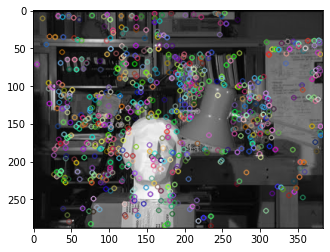

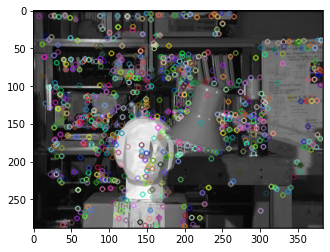

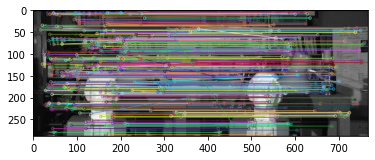

Fundamental Matrix:
[[ 7.49324246e-05 -3.91483688e-03  3.08538583e-01]
 [ 3.67015957e-03  6.11693262e-06  1.71194073e+13]
 [-3.10120793e-01 -1.71194073e+13  1.00000000e+00]]


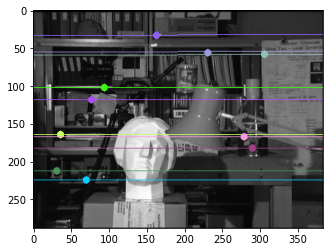

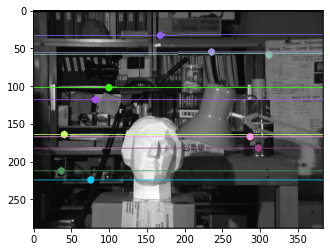

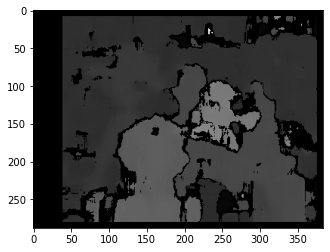

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse


# Function to apply SIFT to given image
def applySIFT(image):
    
    # Creating SIFT object, which will be used for applying SIFT on images
    sift = cv2.SIFT_create()

    # Detecting keypoints and computing keypoint descriptors for the inout images
    keypointsImage, descriptorImage = sift.detectAndCompute(image,None)
    
    return keypointsImage, descriptorImage

# Function to get good matches, given feature descriptors
def getGoodMatches(descriptorImage1, descriptorImage2):
    
    # Applying Brute Force matcher for getting K nearest neighbours
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptorImage1, descriptorImage2, k=2)

    goodList = []
    good = []

    # Filtering good matches based on a distance of 0.75 
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            goodList.append([m])
            good.append(m)
            
    return goodList, good

# Function to get Inliers after RANSAC, accepts mask returned
def getInliers(mask, num=10):
    matchesMask = mask.ravel().tolist()
    indices = []
    for ind in range(len(matchesMask)):
        if matchesMask[ind] == 1:
            indices.append(ind)
    matchesMask = [0]*len(matchesMask)
    np.random.shuffle(indices)
    indices = indices[:num]
    for ind in indices:
            matchesMask[ind] = 1
    return matchesMask


image1=cv2.imread('Q1-Left.jpg')
image2=cv2.imread('Q1-Right.jpg')

# Detecting keypoints and computing keypoint descriptors for the 2 inout images
keypointsImage1, descriptorImage1 = applySIFT(image1)
keypointsImage2, descriptorImage2 = applySIFT(image2)

# Writing the matches detected in the 2 images to the filesystem
Image1Keypoints=cv2.drawKeypoints(image1,keypointsImage1,None)
plt.imshow(Image1Keypoints)
plt.show()

Image2Keypoints=cv2.drawKeypoints(image2,keypointsImage2,None)
plt.imshow(Image2Keypoints)
plt.show()

# Get good matches using KNN algorithm between kepoint descriptors of 
goodList, good = getGoodMatches(descriptorImage1, descriptorImage2)

# Plotting knn matches based on the keypoint distances computed
imagePlot = cv2.drawMatchesKnn(image1,keypointsImage1,image2,keypointsImage2,goodList,None,flags=2)
# cv2.imwrite('Results/task2_matches_knn.jpg',imagePlot)
plt.imshow(imagePlot)
plt.show()

# Getting keypoint locations as an array of (x,y) pixel coordinates
ptsImage1 = np.int32(np.round([keypointsImage1[m.queryIdx].pt for m in good]).reshape(-1,1,2))
ptsImage2 = np.int32(np.round([keypointsImage2[m.trainIdx].pt for m in good]).reshape(-1,1,2))

# Getting Fundamental matrix after applying RANSAC on
# well matched keypoints on both images 
F, mask = cv2.findFundamentalMat(ptsImage1,ptsImage2,cv2.RANSAC,1)

# Get 10 inlier matches after applying RANSAC
matchesMask = getInliers(mask, 10)
inlierImage = cv2.drawMatches(image1,keypointsImage1,image2,keypointsImage2,
                              good,None,matchesMask = matchesMask,flags = 2)

# Applying mask on the keypoints to get 10 inlier pairs
ptsImage1 = ptsImage1[np.array(matchesMask).ravel() == 1]
ptsImage2 = ptsImage2[np.array(matchesMask).ravel() == 1]


# Iterate over 10 inliers to calculate epilines
h ,w, d = image1.shape
for i in range(len(ptsImage1)):
    
    color = tuple(np.random.randint(0,255,3).tolist())
    
    # Calculate epilines on image 2 for keypoints on image1
    line2 = cv2.computeCorrespondEpilines(ptsImage1[i], 1, F)
    
    # Calculate epilines on image 1 for keypoints on image2
    line1 = cv2.computeCorrespondEpilines(ptsImage2[i], 2, F)
    
    # Compute 2 sample points on each line for plotting
    p1 = map(int , [0,-line1.ravel()[2]/line1.ravel()[1]])
    p2 = map(int, [w, -(line1.ravel()[2]+line1.ravel()[0]*w)/line1.ravel()[1]])
    p3 = map(int , [0,-line2.ravel()[2]/line2.ravel()[1]])
    p4 = map(int, [w, -(line2.ravel()[2]+line2.ravel()[0]*w)/line2.ravel()[1]])

    # Draw epilines on corresponding image
    image1EpipolarLines = cv2.line(image1, tuple(p1), tuple(p2), color,1)
    image2EpipolarLines = cv2.line(image2, tuple(p3), tuple(p4), color,1)
    
    # Draw keypoints on corresponding image
    image1Final = cv2.circle(image1EpipolarLines, tuple(ptsImage1[i].ravel()), 2, color,5)
    image2Final = cv2.circle(image2EpipolarLines, tuple(ptsImage2[i].ravel()), 2, color,5)

print('Fundamental Matrix:')
print(F)

plt.imshow(image2Final)
plt.show()

plt.imshow(image1Final)
plt.show()

# Compute disparity between 2 images to create depth map
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=17)
disparity = stereo.compute(cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY),cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY))

plt.imshow(disparity, cmap='gray')
plt.show()


# Question 2

# Prepration

# Read Image and Find Harris Corners

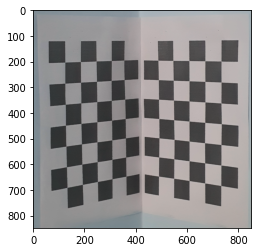

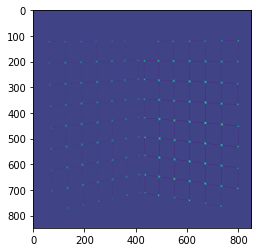

[586, 606]
2


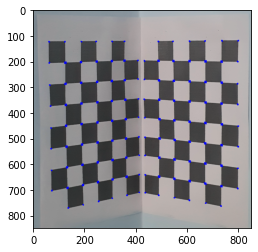

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

filename = 'chessboard.PNG'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# I = rgb2gray(I)
plt.imshow(img)
plt.show()


gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,13,0.01)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
plt.imshow(dst)
plt.show()

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

points=np.unravel_index(dst.argmax(),dst.shape)
print(list(points))
print(len(list(points)))

plt.imshow(img)
plt.show()

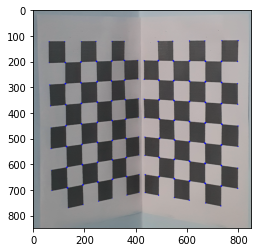

In [123]:
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

dst = cv2.cornerHarris(gray,5,3,0.04)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)


# for i in range(1, len(corners)):
#     print(corners[i])

img[dst>0.1*dst.max()]=[0,0,255]
plt.imshow(img)

# Harris Corners Location
Locations of x and y of harris corners are extracted. There are 123 corners detected

In [60]:
milimetr_corners = []
for i,j in corners:
    milimetr_corners.append([int(i * 10), int(j * 10)])
print(milimetr_corners)
print(len(milimetr_corners))

[[2124, 2575], [4050, 770], [3707, 795], [3384, 817], [3076, 840], [75, 888], [2764, 863], [465, 892], [837, 895], [1182, 896], [1524, 895], [1817, 895], [2483, 879], [3704, 1239], [4036, 1228], [3076, 1259], [3384, 1248], [2493, 1279], [2770, 1272], [1815, 1293], [1194, 1316], [1533, 1304], [2114, 1283], [2233, 1286], [482, 1337], [844, 1327], [84, 1344], [2117, 1662], [2236, 1665], [2504, 1668], [2775, 1673], [3076, 1674], [3382, 1676], [3703, 1678], [1824, 1683], [1535, 1706], [4032, 1684], [1211, 1728], [854, 1753], [493, 1777], [101, 1806], [2124, 2039], [2507, 2056], [1836, 2070], [2233, 2046], [2782, 2069], [3077, 2083], [3383, 2096], [1543, 2103], [3701, 2113], [1223, 2136], [4035, 2128], [867, 2172], [506, 2210], [123, 2246], [2133, 2411], [2246, 2414], [2516, 2437], [1848, 2452], [2790, 2460], [1551, 2494], [3080, 2485], [3381, 2513], [1229, 2540], [3712, 2538], [876, 2586], [4049, 2569], [518, 2636], [148, 2694], [2136, 2781], [2253, 2786], [2523, 2817], [1856, 2832], [2802,

# Find Real World Corners Location
Now when we calculate the real world size of each square, we find that its 2.9. There is an apporximate of 5mm before the chess board starts but here we did not added to values. There are 122 corners in real world.

In [43]:
world_corners_y = []
for i in range(7):
    for j in range(9):
        if (i == 0 and j == 0) or (i == 6 and j == 8):
            continue;
        world_corners_y.append((0, i*29, j*29))
print(world_corners_y)
print(len(world_corners_y))

world_corners_x = []
for i in range(7):
    for j in range(9):
        if (i == 6 and j == 0) or (i == 0 and j == 8):
            continue
        world_corners_x.append((i*29, 0, j*29))
print(world_corners_x)
print(len(world_corners_x))
    
    
world_corners = world_corners_x + world_corners_y
print(world_corners)
print(len(world_corners))

[(0, 0, 29), (0, 0, 58), (0, 0, 87), (0, 0, 116), (0, 0, 145), (0, 0, 174), (0, 0, 203), (0, 0, 232), (0, 29, 0), (0, 29, 29), (0, 29, 58), (0, 29, 87), (0, 29, 116), (0, 29, 145), (0, 29, 174), (0, 29, 203), (0, 29, 232), (0, 58, 0), (0, 58, 29), (0, 58, 58), (0, 58, 87), (0, 58, 116), (0, 58, 145), (0, 58, 174), (0, 58, 203), (0, 58, 232), (0, 87, 0), (0, 87, 29), (0, 87, 58), (0, 87, 87), (0, 87, 116), (0, 87, 145), (0, 87, 174), (0, 87, 203), (0, 87, 232), (0, 116, 0), (0, 116, 29), (0, 116, 58), (0, 116, 87), (0, 116, 116), (0, 116, 145), (0, 116, 174), (0, 116, 203), (0, 116, 232), (0, 145, 0), (0, 145, 29), (0, 145, 58), (0, 145, 87), (0, 145, 116), (0, 145, 145), (0, 145, 174), (0, 145, 203), (0, 145, 232), (0, 174, 0), (0, 174, 29), (0, 174, 58), (0, 174, 87), (0, 174, 116), (0, 174, 145), (0, 174, 174), (0, 174, 203)]
61
[(0, 0, 0), (0, 0, 29), (0, 0, 58), (0, 0, 87), (0, 0, 116), (0, 0, 145), (0, 0, 174), (0, 0, 203), (29, 0, 0), (29, 0, 29), (29, 0, 58), (29, 0, 87), (29, 0

# Calculating the Camera Matrix
Here we find the camera matrix using the real world coordinates. Here we use 31 point of the real world and we had 122 of them. So we shuffle the elements so random points were selected.

In [104]:
# The homogeneous matrix
n = 32
P = np.zeros((2 * n, 12))
world_corners = shuffle(world_corners)

j = 0
for i in range(0, 64, 2):
    P[i][0] = world_corners[j][0]; P[i+1][4] = world_corners[j][0]
    P[i][1] = world_corners[j][1]; P[i+1][5] = world_corners[j][1]
    P[i][2] = world_corners[j][2]; P[i+1][6] = world_corners[j][2]
    P[i][3] = 1; P[i+1][7] = 1
    P[i][8:12] = P[i][0:4]*-1*milimetr_corners[j][0]
    P[i+1][8:12] = P[i][0:4]*-1*milimetr_corners[j][1]
    j = j + 1

import pandas as pd
display(pd.DataFrame(P))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-2124.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-2575.0
2,0.0,0.0,29.0,1.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-117450.0,-4050.0
3,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.0,-0.0,-0.0,-22330.0,-770.0
4,0.0,0.0,58.0,1.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-215006.0,-3707.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.0,0.0,0.0,0.0,87.0,0.0,87.0,1.0,-145116.0,-0.0,-145116.0,-1668.0
60,87.0,0.0,116.0,1.0,0.0,0.0,0.0,0.0,-241425.0,-0.0,-321900.0,-2775.0
61,0.0,0.0,0.0,0.0,87.0,0.0,116.0,1.0,-145551.0,-0.0,-194068.0,-1673.0
62,87.0,0.0,145.0,1.0,0.0,0.0,0.0,0.0,-267612.0,-0.0,-446020.0,-3076.0


Now by using SVD decomposition we can find M which the Extrinsic Parameters will be extracted from.

In [105]:
# singular value decomposition to find 'm' which is the singular column of
# 'V' with minimum values.
import scipy.linalg as la

U = np.dot(np.transpose(P) , P);
display(pd.DataFrame(U))

D,V = la.eig(U);
# V = np.diag(V).astype(int)

display(pd.DataFrame(V))
display(pd.DataFrame(D))

M = np.zeros((3,4));

j=0;
for i in range(3):
    M[i][0] = V[j + 0][0];
    M[i][1] = V[j + 1][0];
    M[i][2] = V[j + 2][0];
    M[i][3] = V[j + 3][0];
    j = j + 4;
    
display(pd.DataFrame(M))

,0,1,2,3,4,5,6,7,8,9,10,11
0,83259.0,0.0,1.286730e+05,1305.0,0.0,0.0,0.0,0.0,-1.674288e+08,0.0,-2.801472e+08,-2.649875e+06
1,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2,128673.0,0.0,5.071230e+05,3335.0,0.0,0.0,0.0,0.0,-2.801472e+08,0.0,-1.095270e+09,-7.420404e+06
3,1305.0,0.0,3.335000e+03,32.0,0.0,0.0,0.0,0.0,-2.649875e+06,0.0,-7.420404e+06,-6.995800e+04
4,0.0,0.0,0.000000e+00,0.0,83259.0,0.0,128673.0,1305.0,-1.205960e+08,0.0,-1.771794e+08,-1.794694e+06
5,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
6,0.0,0.0,0.000000e+00,0.0,128673.0,0.0,507123.0,3335.0,-1.771794e+08,0.0,-6.097048e+08,-3.986514e+06
7,0.0,0.0,0.000000e+00,0.0,1305.0,0.0,3335.0,32.0,-1.794694e+06,0.0,-3.986514e+06,-3.925700e+04
8,-167428803.0,0.0,-2.801472e+08,-2649875.0,-120596036.0,0.0,-177179357.0,-1794694.0,5.878892e+11,0.0,9.850045e+11,9.107074e+09
9,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.000075,-0.000275,0.001119,0.144604,0.213172,-0.560052,-0.787325,0.008913,5.311872e-03,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.0,0.0,0.0
2,-0.000271,0.000063,0.001423,0.474777,0.832695,0.251610,0.133727,0.003523,1.063200e-03,0.0,0.0,0.0
3,-0.000002,-0.000002,0.000280,0.003203,0.005153,-0.004526,-0.007960,-0.882279,-4.705987e-01,0.0,0.0,0.0
4,-0.000049,-0.000219,0.000873,-0.226970,-0.008647,0.772206,-0.593323,0.004443,-7.358615e-03,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.0,0.0
6,-0.000152,-0.000030,-0.005070,-0.837910,0.510946,-0.163310,0.100603,0.002162,-4.295450e-03,0.0,0.0,0.0
7,-0.000001,-0.000002,0.000129,-0.005707,0.002877,0.006300,-0.004126,-0.470603,8.822896e-01,0.0,0.0,0.0
8,0.264827,0.964267,0.007440,-0.000098,0.000112,-0.000005,-0.000336,0.000003,5.204838e-07,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,1.0


,0
0,4.174657e+12+0.000000e+00j
1,3.173829e+11+0.000000e+00j
2,5.204937e+07+0.000000e+00j
3,5.405086e+05+0.000000e+00j
4,1.078515e+05+0.000000e+00j
5,4.636578e+04+0.000000e+00j
6,7.685543e+03+0.000000e+00j
7,1.152145e+00+0.000000e+00j
8,5.783338e+00+0.000000e+00j
9,0.000000e+00+0.000000e+00j


,0,1,2,3
0,-0.000075,0.0,-0.000271,-0.000002
1,-0.000049,0.0,-0.000152,-0.000001
2,0.264827,0.0,0.964273,0.006604


# Extracting intrinsic and extrinsic parameters

In [106]:
A1 = np.zeros(3)
A2 = np.zeros(3)
A3 = np.zeros(3)
B = np.zeros(3)

A1[0] = M[0][0]
A1[1] = M[0][1]
A1[2] = M[0][2]

A2[0] = M[1][0]
A2[1] = M[1][1]
A2[2] = M[1][2]

A3[0] = M[2][0]
A3[1] = M[2][1]
A3[2] = M[2][2]

B = M[:,3]


display(pd.DataFrame(M))

,0,1,2,3
0,-0.000075,0.0,-0.000271,-0.000002
1,-0.000049,0.0,-0.000152,-0.000001
2,0.264827,0.0,0.964273,0.006604


We have [A1:A2:A3] and t (translation matrix) as our parameters

In [110]:
f = np.linalg.norm(A3);
R3 = (1/f)*A3; # rotation matrix1

e = np.dot(A2,np.transpose(R3));
temp = A2 - e * R3; 
d = np.linalg.norm(temp);
R2 = (1/d)*temp; # rotation matrix2

c = np.dot(A1, np.transpose(R3));
b = np.dot(A1, np.transpose(R2));
temp2 = A1 -(b * R2) - (c * R3);

a = np.linalg.norm(temp2);
R1 = (1/a) * temp2; # rotation matrix3


display(pd.DataFrame(R1))
display(pd.DataFrame(R2))
display(pd.DataFrame(R3))
display(pd.DataFrame(B))

,0
0,-0.886585
1,0.000000
2,0.462566


,0
0,-0.964294
1,0.000000
2,0.264833


,0
0,0.264833
1,0.000000
2,0.964294


,0
0,-0.000002
1,-0.000001
2,0.006604


# Normalizing values with respect to f since f = 1 on matrix K.

In [114]:
# These are Intrinsic parameters.
alpha = a / f;
skew = b / f;
u_0 = c / f;
beta_sinTheta = d / f;
v_0 = e / f;
f = f / f;

# Intrinsic Parameter Matrix.
K =[[alpha,     skew,       u_0],
    [0,      beta_sinTheta, v_0],
    [0,          0,         f]]  


display(pd.DataFrame(K))

# Extrinsic Parameters
display(pd.DataFrame(R1))
display(pd.DataFrame(R2))
display(pd.DataFrame(R3))
display(pd.DataFrame(B))

,0,1,2
0,3.515830e-19,9.353418e-07,-0.000281
1,0.000000e+00,6.568830e-06,-0.000160
2,0.000000e+00,0.000000e+00,1.000000


,0
0,-0.886585
1,0.000000
2,0.462566


,0
0,-0.964294
1,0.000000
2,0.264833


,0
0,0.264833
1,0.000000
2,0.964294


,0
0,-0.000002
1,-0.000001
2,0.006604
